всем привет это наш код по проекту. чтобы его запустить попросите отправить вам архим clin_rec_html и загрузите его в папку проекта.

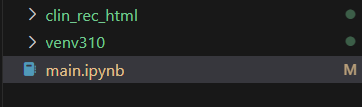

Дальше просто запустите проект

In [7]:
import os
from bs4 import BeautifulSoup

In [8]:
import os
print("Current directory:", os.getcwd())
print("File exists:", os.path.exists('html_dataset/01_Rak_pecheni_gcc.html'))
if os.path.exists('html_dataset'):
    print("Files in html_dataset:", os.listdir('html_dataset'))


Current directory: d:\магистратура сколтех\med_ai_code
File exists: False


In [9]:
from bs4 import BeautifulSoup
import re
import json
import os  # ДОБАВИТЬ ИМПОРТ

# ---- 1. Маппинг ключевых секций ---- #
target_patterns = {
    "definition": "Определение заболевания",
    "etiology": "Этиология", 
    "epidemiology": "Эпидемиология",
    "clinical_picture": "Клиническая картина",
    "diagnostics": "Диагностика",
    "complaints_anamnesis": "Жалобы и анамнез",
    "physical_examination": "Физикальное обследование",
    "lab_diagnostics": "Лабораторные диагностические исследования",
    "instrumental_diagnostics": "Инструментальные диагностические исследования",
    "other_diagnostics": "Иные диагностические исследования",
    "additional_info": "Дополнительная информация",
}

def extract_additional_info(sections_raw):
    info_key = [k for k in sections_raw if k.startswith("7. Дополнительная информация")]
    if info_key:
        return sections_raw[info_key[0]]
    else:
        for k in sections_raw:
            if "Дополнительная информация" in k:
                return sections_raw[k]
    return ""

# ДОБАВИТЬ ОТСУТСТВУЮЩИЕ ФУНКЦИИ
def find_section_in_html(soup, section_name):
    """Находит HTML-элемент секции по имени"""
    # Простая реализация - ищем по тексту заголовка
    for tag in soup.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6']):
        if section_name.strip() in tag.get_text().strip():
            return tag.parent or tag
    return None

def extract_image_caption(img):
    """Извлекает подпись к изображению"""
    # Ищем caption в соседних элементах
    parent = img.parent
    if parent:
        # Ищем figcaption
        caption = parent.find('figcaption')
        if caption:
            return caption.get_text().strip()
        
        # Ищем в следующем элементе
        next_sibling = img.find_next_sibling()
        if next_sibling and next_sibling.name in ['p', 'div', 'span']:
            text = next_sibling.get_text().strip()
            if len(text) < 200:  # Вероятно подпись
                return text
    
    return img.get('alt', '')

def find_parent_section(img):
    """Находит родительскую секцию для изображения"""
    current = img
    while current:
        current = current.parent
        if current and current.name in ['div', 'section']:
            # Ищем заголовок в этой секции
            header = current.find(['h1', 'h2', 'h3', 'h4', 'h5', 'h6'])
            if header:
                return header.get_text().strip()
        if current.name == 'body':
            break
    return "Unknown section"

def extract_surrounding_text(img, chars=200):
    """Извлекает окружающий текст вокруг изображения"""
    context = []
    
    # Текст до изображения
    prev_sibling = img.find_previous_sibling()
    if prev_sibling:
        prev_text = prev_sibling.get_text().strip()
        if prev_text:
            context.append(prev_text[-chars//2:])
    
    # Текст после изображения  
    next_sibling = img.find_next_sibling()
    if next_sibling:
        next_text = next_sibling.get_text().strip()
        if next_text:
            context.append(next_text[:chars//2])
    
    return " ... ".join(context)

def classify_appendix_type(title, content):
    """Классифицирует тип приложения"""
    title_lower = title.lower()
    if 'алгоритм' in title_lower:
        return 'algorithm'
    elif 'таблица' in title_lower:
        return 'table'
    elif 'схема' in title_lower or 'диаграмма' in title_lower:
        return 'diagram'
    return 'other'

def extract_tables_from_section(soup, section_name):
    """Извлекает таблицы из конкретной секции"""
    tables = []
    
    # Найти все таблицы в документе
    for table in soup.find_all('table'):
        # Найти ближайший заголовок к таблице
        parent_header = find_nearest_header(table)
        
        if parent_header and section_name.strip() in parent_header.get_text().strip():
            # Извлечь содержимое таблицы
            table_data = parse_table_content(table)
            tables.append({
                'content': table_data,
                'html': str(table),
                'caption': extract_table_caption(table)
            })
    
    return tables

def parse_table_content(table):
    """Преобразует HTML таблицу в структурированные данные"""
    rows = []
    for row in table.find_all('tr'):
        cells = []
        for cell in row.find_all(['td', 'th']):
            cells.append(cell.get_text().strip())
        if cells:  # Только непустые строки
            rows.append(cells)
    return rows


def extract_table_caption(table):
    """Извлекает подпись к таблице"""
    # Ищем caption внутри таблицы
    caption = table.find('caption')
    if caption:
        return caption.get_text().strip()
    
    # Ищем заголовок перед таблицей
    prev_element = table.find_previous_sibling()
    if prev_element and prev_element.name in ['p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
        text = prev_element.get_text().strip()
        if 'таблица' in text.lower():
            return text
    
    return ""

def find_nearest_header(element):
    """Находит ближайший заголовок к элементу"""
    current = element
    while current:
        current = current.find_previous(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'div'])
        if current and current.name in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
            return current
        if current and current.name == 'div' and current.get('class'):
            # Если дошли до большого раздела, останавливаемся
            break
    return None

def extract_applications_with_media(soup, sections_raw):
    apps = {}
    
    # Извлечь все приложения из уже найденных секций
    for sname, sbody in sections_raw.items():
        if "Приложение" in sname:
            print(f"Processing application: {sname}")  # DEBUG
            
            # Найти все таблицы в этой секции через BeautifulSoup
            tables = extract_tables_from_section(soup, sname)
            
            # Найти изображения (уже работает)
            app_section = find_section_in_html(soup, sname)
            images = []
            if app_section:
                for img in app_section.find_all('img'):
                    images.append({
                        'src': img.get('src', ''),
                        'alt': img.get('alt', ''),
                        'caption': extract_image_caption(img)
                    })
            
            apps[sname] = {
                'text': sbody,
                'images': images,
                'tables': tables,  # ДОБАВИТЬ ТАБЛИЦЫ
                'type': classify_appendix_type(sname, sbody)
            }
    
    return apps

def extract_all_images(soup):
    """Извлекает все изображения с контекстом"""
    images = []
    for img in soup.find_all('img'):
        parent_section = find_parent_section(img)
        
        images.append({
            'src': img.get('src', ''),
            'alt': img.get('alt', ''),
            'caption': extract_image_caption(img),
            'section': parent_section,
            'context': extract_surrounding_text(img, 200)
        })
    return images

def parse_html_medical(filepath):
    with open(filepath, encoding='utf-8') as f:
        soup = BeautifulSoup(f, 'html.parser')

    # ---- 2. Собрать весь текст body ---- #
    body_text = soup.body.get_text(separator='\n', strip=True)
    lines = [line.strip() for line in body_text.split('\n') if line.strip()]

    # ---- 3. Найти метаданные (title) ---- #
    title = soup.title.get_text(strip=True) if soup.title else filepath

    # ---- 4. Собрать секции по regex ---- #
    section_start = re.compile(r"^([0-9]+(?:\.[0-9]+)*\.? .+|Приложение .+)")  
    sections_raw = {}
    current_section = None
    buffer = []
    for line in lines:
        if section_start.match(line):
            if current_section:
                sections_raw[current_section] = "\n".join(buffer).strip()
                buffer = []
            current_section = line
        else:
            if current_section:
                buffer.append(line)
    if current_section and buffer:
        sections_raw[current_section] = "\n".join(buffer).strip()

    print("------ Найденные приложения -------")
    for k in sections_raw.keys():
        if "Приложение" in k:
            print(f"FOUND: {k}")
            print(f"Content length: {len(sections_raw[k])}")

    #print("------ Найденные секции -------")
    #for k in sections_raw.keys():
    #    print(k)

    # ---- 5. Маппировать к целевым ключам ---- #
    final_sections = {k: "" for k in target_patterns}
    for key, pat in target_patterns.items():
        for sname, sbody in sections_raw.items():
            if pat.lower() in sname.lower():
                final_sections[key] = sbody

    # Извлечь медиа и приложения
    all_images = extract_all_images(soup)
    applications = extract_applications_with_media(soup, sections_raw)
    final_sections['additional_info'] = extract_additional_info(sections_raw)

    # ---- 6. Сохранить итоговый JSON ---- #
    output = {
        "title": title,
        "sections": final_sections,
        "images": all_images,
        "applications": applications,
        "media_summary": {
            "total_images": len(all_images),
            "algorithms": len([a for a in applications.values() if a.get('type') == 'algorithm']),
            "diagrams": len([a for a in applications.values() if a.get('type') == 'diagram'])
        }
    }

    # Готовим путь
    basename = os.path.splitext(os.path.basename(filepath))[0]
    outdir = os.path.join(os.getcwd(), 'clear_dataset')
    os.makedirs(outdir, exist_ok=True)
    outpath = os.path.join(outdir, f'{basename}.parsed.json')
    
    with open(outpath, 'w', encoding='utf-8') as f:
        json.dump(output, f, ensure_ascii=False, indent=2)
    print(f"Parsed: {outpath}")
    return 0


# ---- 7. Как запускать ---- #
#это код для работы только с 1 файлом, я сейчас его почистил
#filepath = os.path.abspath('html_dataset/01_Rak_pecheni_gcc.html')
#print(f"Absolute path: {filepath}")
#parse_html_medical(filepath)



Это основной код для очистки html датасета, он проходит по всем файлам в папке clin_rec_html и превращает их в более очищенные файлы, которые засовывает в clear_dataset

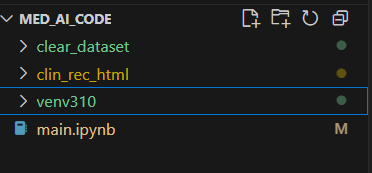

работать будет много потому что файлов в clin_rec около 1000

In [ ]:
def batch_parse_html(directory):
    files = [f for f in os.listdir(directory) if f.lower().endswith('.html')]
    for filename in files:
        filepath = os.path.join(directory, filename)
        print(f"Parsing: {filepath}")
        parse_html_medical(filepath)  # ваша функция парсинга

# ---- запустить ----
batch_parse_html('clin_rec_html')

Parsing: clin_rec_html\485_2_Аскаридоз_у_детей.html
------ Найденные приложения -------
FOUND: Приложение А1. Состав рабочей группы по разработке и пересмотру клинических рекомендаций
Content length: 1461
FOUND: Приложение А2. Методология разработки клинических рекомендаций
Content length: 4548
FOUND: Приложение А3. Справочные материалы, включая соответствие показаний к применению и противопоказаний, способов применения и доз лекарственных препаратов, инструкции по применению лекарственного препарата
Content length: 1790
FOUND: Приложение Б. Алгоритмы действий врача
Content length: 0
FOUND: Приложение В. Информация для пациента
Content length: 2140
FOUND: Приложение Г1-ГN. Шкалы оценки, вопросники и другие оценочные инструменты состояния пациента, приведенные в клинических рекомендациях
Content length: 272
Processing application: Приложение А1. Состав рабочей группы по разработке и пересмотру клинических рекомендаций
Processing application: Приложение А2. Методология разработки клиниче

KeyboardInterrupt: 

In [ ]:
from collections import Counter
keys = Counter()
for fname in os.listdir('clear_dataset'):
    if fname.endswith('.json'):
        doc = json.load(open(os.path.join('clear_dataset', fname), encoding='utf-8'))
        if 'sections' in doc:
            keys.update(doc['sections'].keys())
print(keys)

Counter({'definition': 238, 'etiology': 238, 'epidemiology': 238, 'clinical_picture': 238, 'diagnostics': 238, 'complaints_anamnesis': 238, 'physical_examination': 238, 'lab_diagnostics': 238, 'instrumental_diagnostics': 238, 'other_diagnostics': 238, 'additional_info': 238})


In [ ]:
# Пути к папке с результатами
DATA_DIR = "clear_dataset"
OUT_DIR = "clean_dataset"
os.makedirs(OUT_DIR, exist_ok=True)

# Единые ключи разделов
SECTION_KEYS = {
    "diagnostics": "diagnostics",
    "complaints_anamnesis": "complaints_anamnesis",
    "physical_examination": "physical_examination",
    "lab_diagnostics": "lab_diagnostics",
    # Добавь нужные поля!
}

for fname in os.listdir(DATA_DIR):
    if not fname.endswith('.json'):
        continue
    with open(os.path.join(DATA_DIR, fname), encoding='utf-8') as f:
        doc = json.load(f)
    # Чистим title
    doc['title'] = clean_text(doc.get('title', ''))
    # Чистим секции
    if 'sections' in doc:
        cleaned_sections = {}
        for key, value in doc['sections'].items():
            std_key = SECTION_KEYS.get(key, key)
            cleaned_sections[std_key] = clean_text(value)
        doc['sections'] = cleaned_sections

    # Сохраняем очищенный файл
    outpath = os.path.join(OUT_DIR, fname)
    with open(outpath, 'w', encoding='utf-8') as f:
        json.dump(doc, f, ensure_ascii=False, indent=2)
    print(f"Cleaned: {fname}")

'd:\\магистратура сколтех\\med_ai_code'

какие файлы надо бы загрузить 

создайте виртуальное окружение на версии 3.12 и теперь загрузите библиотеки снизу

In [ ]:
# %pip install llama-index chromadb ollama sentence-transformers

In [ ]:
#pip install langchain langchain-community langchain-chroma langchain-ollama unstructured langchain-core
